In [1174]:
import datetime
import sys
import os

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import itertools
from workalendar.usa import Texas
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from cond_rnn import ConditionalRNN
from sklearn.preprocessing import MinMaxScaler
from collections import UserDict

from src.functions import load_data, mape, TimeSeriesTensor, create_evaluation_df, series_to_supervised

np.set_printoptions(threshold=sys.maxsize)
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
DAYS_IN_YEAR = 365
HOURS_IN_DAY = 24
DAYS_OF_WEEK = ['week_1','week_2','week_3','week_4','week_5','week_6','week_7']
MINUTES_IN_HOUR = 60
SECONDS_IN_MINUTE = 60
MINUTES_IN_DAY = MINUTES_IN_HOUR * HOURS_IN_DAY

In [768]:
def get_fractional_hour_from_series(series: pd.Series) -> pd.Series:
    """
    Return fractional hour in range 0-24, e.g. 12h30m --> 12.5.
    Accurate to 1 minute.
    """
    hour = series.hour
    minute = series.minute
    return hour + minute / MINUTES_IN_HOUR

def get_fractional_day_from_series(series: pd.Series) -> pd.Series:
    """
    Return fractional day in range 0-1, e.g. 12h30m --> 0.521.
    Accurate to 1 minute
    """
    fractional_hours = get_fractional_hour_from_series(series)
    return fractional_hours / HOURS_IN_DAY

def get_fractional_year_from_series(series: pd.Series) -> pd.Series:
    """
    Return fractional year in range 0-1.
    Accurate to 1 day
    """
    return (series.dayofyear - 1) / DAYS_IN_YEAR

def normalize(self, tensor):
    self.scaler = MinMaxScaler(feature_range=(0, 1))
    tensor = self.scaler.fit_transform(tensor)
    return tensor

def preprocess(dataframe):
    dataframe.index = pd.to_datetime(dataframe.index)
    # Removing duplicates
    dataframe = dataframe[~dataframe.index.duplicated()]

    #Filling NaN values
    dataframe = dataframe.interpolate()

    # Setting the calendar holidats
    cal = Texas()
    years = list(range(2014, 2025))
    holidays = []
    for year in years:
        holidays.extend(cal.holidays(year))

    dataframe = dataframe.sort_index()

    #print('preprocess:')
    #print(dataframe.columns)
    # Rename the target column to 'Valeur' for convenience
    dataframe.rename(columns={dataframe.columns[0]: 'value'}, inplace=True)

    # Logarithmic transform add 1 for non-negative data (zeros in the series)
    #dataframe[self.Y_var] = log(dataframe[self.Y_var] + 1)

    #working day {0,1}
    dataframe['working day'] = dataframe.index.map(cal.is_working_day).astype(np.float32)

    #fractional hour [0,1]
    dataframe['fractional hour'] = get_fractional_day_from_series(dataframe.index)

    # day of week one-hot encoded
    dataframe['day of week'] = dataframe.index.dayofweek + 1
    dataframe['day of week'] = pd.Categorical(dataframe['day of week'], categories=[1,2,3,4,5,6,7], ordered=True)
    dataframe = pd.get_dummies(dataframe,prefix=['week'], columns = ['day of week'], drop_first=False)
    #dataframe = pd.concat([dataframe, pd.DataFrame(columns=DAYS_OF_WEEK)]).fillna(0)


    # fractional day of year
    dataframe['day of year'] = get_fractional_year_from_series(dataframe.index)

    # we encode cynical data into two dimensions using a sine and cosine transformations
    def encode(data, col, max_val):
        data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
        data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
        return data
    dataframe = encode(dataframe, 'fractional hour', HOURS_IN_DAY)
    dataframe = encode(dataframe, 'day of year', DAYS_IN_YEAR)
    # dropping original columns
    dataframe = dataframe.drop(['fractional hour','day of year'], axis=1)
    return dataframe

In [1142]:
csv_path = '../data/ERCOT/ercot_data.csv'
df = pd.read_csv(csv_path, index_col=0)

In [1143]:
df = preprocess(df)

In [1144]:
df
c1 = df.iloc[:,2:10]
c2 = series_to_supervised(df)
df = df.iloc[:,[0,1,-4,-3,-2,-1]].copy()
c1 = c1.loc[c2.index]
df = df['2012-01-07 02:00:00':]

In [1145]:
print(c1.shape)
print(c2.shape)
print(df.shape)

(34892, 8)
(34892, 2)
(34915, 6)


In [1146]:
test_df = df.copy()['2015':]
test_c1 = c1.copy()['2015':]
test_c2 = c2.copy()['2015':]

n_test = len(test_df)
index = len(df) - n_test
train_val_split = 0

train_df = df.copy()[:int(index * (1-train_val_split))]
train_c1 = c1.copy()[:int(index * (1-train_val_split))]
train_c2 = c2.copy()[:int(index * (1-train_val_split))]

val_df = df.copy()[int(index * (1-train_val_split)):index]
val_c1 = c1.copy()[:int(index * (1-train_val_split))]
val_c2 = c2.copy()[:int(index * (1-train_val_split))]

num_features = df.shape[1]

In [1147]:
y_scaler = MinMaxScaler()
y_scaler.fit(train_df[['value']])

MinMaxScaler()

In [1148]:
train_c2[['value(t-24)']] = y_scaler.fit_transform(train_c2[['value(t-24)']])

In [1149]:
train_c2[['value(t-168)']] = y_scaler.fit_transform(train_c2[['value(t-168)']])

In [1150]:
X_scaler = MinMaxScaler()
train_df[train_df.columns] = X_scaler.fit_transform(train_df)
test_df[train_df.columns] = X_scaler.fit_transform(test_df)

In [1151]:
T = 24
HORIZON = 24
tensor_structure = {'X':(range(-T+1, 1), ['value', 'Temperatures (°C)','fractional hour_sin','fractional hour_cos','day of year_sin','day of year_cos'])}
train_inputs = TimeSeriesTensor(train_df, 'value', HORIZON, tensor_structure)

In [1152]:
test_inputs = TimeSeriesTensor(test_df, 'value', HORIZON, tensor_structure)

In [1153]:
print(train_inputs.dataframe.shape)
print(c1.shape)
print(c2.shape)

(25967, 168)
(34892, 8)
(34892, 2)


In [1162]:
train_c1 = c1.reindex(train_inputs.dataframe.index)
train_c2 = c2.reindex(train_inputs.dataframe.index)

In [1167]:
print(train_inputs.dataframe.shape)
print(train_c1.shape)
print(train_c2.shape)

(25967, 168)
(25967, 8)
(25967, 2)


In [1173]:
train_inputs.dataframe[train_inputs.dataframe.isna().any(axis=1)]

Empty DataFrame
Columns: [(target, y, t+1), (target, y, t+2), (target, y, t+3), (target, y, t+4), (target, y, t+5), (target, y, t+6), (target, y, t+7), (target, y, t+8), (target, y, t+9), (target, y, t+10), (target, y, t+11), (target, y, t+12), (target, y, t+13), (target, y, t+14), (target, y, t+15), (target, y, t+16), (target, y, t+17), (target, y, t+18), (target, y, t+19), (target, y, t+20), (target, y, t+21), (target, y, t+22), (target, y, t+23), (target, y, t+24), (X, value, t-23), (X, value, t-22), (X, value, t-21), (X, value, t-20), (X, value, t-19), (X, value, t-18), (X, value, t-17), (X, value, t-16), (X, value, t-15), (X, value, t-14), (X, value, t-13), (X, value, t-12), (X, value, t-11), (X, value, t-10), (X, value, t-9), (X, value, t-8), (X, value, t-7), (X, value, t-6), (X, value, t-5), (X, value, t-4), (X, value, t-3), (X, value, t-2), (X, value, t-1), (X, value, t), (X, Temperatures (°C), t-23), (X, Temperatures (°C), t-22), (X, Temperatures (°C), t-21), (X, Temperatures (°C), t-20), (X, Temperatures (°C), t-19), (X, Temperatures (°C), t-18), (X, Temperatures (°C), t-17), (X, Temperatures (°C), t-16), (X, Temperatures (°C), t-15), (X, Temperatures (°C), t-14), (X, Temperatures (°C), t-13), (X, Temperatures (°C), t-12), (X, Temperatures (°C), t-11), (X, Temperatures (°C), t-10), (X, Temperatures (°C), t-9), (X, Temperatures (°C), t-8), (X, Temperatures (°C), t-7), (X, Temperatures (°C), t-6), (X, Temperatures (°C), t-5), (X, Temperatures (°C), t-4), (X, Temperatures (°C), t-3), (X, Temperatures (°C), t-2), (X, Temperatures (°C), t-1), (X, Temperatures (°C), t), (X, fractional hour_sin, t-23), (X, fractional hour_sin, t-22), (X, fractional hour_sin, t-21), (X, fractional hour_sin, t-20), (X, fractional hour_sin, t-19), (X, fractional hour_sin, t-18), (X, fractional hour_sin, t-17), (X, fractional hour_sin, t-16), (X, fractional hour_sin, t-15), (X, fractional hour_sin, t-14), (X, fractional hour_sin, t-13), (X, fractional hour_sin, t-12), (X, fractional hour_sin, t-11), (X, fractional hour_sin, t-10), (X, fractional hour_sin, t-9), (X, fractional hour_sin, t-8), (X, fractional hour_sin, t-7), (X, fractional hour_sin, t-6), (X, fractional hour_sin, t-5), (X, fractional hour_sin, t-4), (X, fractional hour_sin, t-3), (X, fractional hour_sin, t-2), (X, fractional hour_sin, t-1), (X, fractional hour_sin, t), (X, fractional hour_cos, t-23), (X, fractional hour_cos, t-22), (X, fractional hour_cos, t-21), (X, fractional hour_cos, t-20), ...]
Index: []

[0 rows x 168 columns]

In [867]:
print(train_inputs.dataframe.columns.to_numpy())

[('target', 'y', 't+1') ('target', 'y', 't+2') ('target', 'y', 't+3')
 ('target', 'y', 't+4') ('target', 'y', 't+5') ('target', 'y', 't+6')
 ('target', 'y', 't+7') ('target', 'y', 't+8') ('target', 'y', 't+9')
 ('target', 'y', 't+10') ('target', 'y', 't+11') ('target', 'y', 't+12')
 ('target', 'y', 't+13') ('target', 'y', 't+14') ('target', 'y', 't+15')
 ('target', 'y', 't+16') ('target', 'y', 't+17') ('target', 'y', 't+18')
 ('target', 'y', 't+19') ('target', 'y', 't+20') ('target', 'y', 't+21')
 ('target', 'y', 't+22') ('target', 'y', 't+23') ('target', 'y', 't+24')
 ('X', 'value', 't-23') ('X', 'value', 't-22') ('X', 'value', 't-21')
 ('X', 'value', 't-20') ('X', 'value', 't-19') ('X', 'value', 't-18')
 ('X', 'value', 't-17') ('X', 'value', 't-16') ('X', 'value', 't-15')
 ('X', 'value', 't-14') ('X', 'value', 't-13') ('X', 'value', 't-12')
 ('X', 'value', 't-11') ('X', 'value', 't-10') ('X', 'value', 't-9')
 ('X', 'value', 't-8') ('X', 'value', 't-7') ('X', 'value', 't-6')
 ('X', 'v

In [905]:
MAX_EPOCHS = 25
BATCHSIZE = 10
patience = 100

LSTMIMO = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, input_shape=(24, 6), return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(1)
])

In [906]:
LSTMIMO.compile(optimizer=tf.optimizers.Adam(), loss='mse', metrics=[tf.metrics.MeanSquaredError()])

In [907]:
LSTMIMO.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 24, 32)            4992      
_________________________________________________________________
dense_86 (Dense)             (None, 24, 1)             33        
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________


In [912]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

history = LSTMIMO.fit(train_inputs['X'], train_inputs['target'].reshape(-1,24,1), batch_size=32, epochs=MAX_EPOCHS,
                  validation_split=0.15,
                  callbacks=[early_stopping], verbose=1)

Epoch 1/25
690/690 [==============================] - 11s 16ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 2/25
690/690 [==============================] - 11s 16ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 3/25
690/690 [==============================] - 11s 16ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 4/25
690/690 [==============================] - 11s 16ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 5/25
690/690 [==============================] - 11s 16ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 6/25
690/690 [==============================] - 11s 16ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 7/25
690/6

In [913]:
def plot_train_history(model):
    '''
    Convergence plots to have an idea on how the training performs
    '''
    loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']
    plt.figure()
    plt.plot(range(len(loss)), loss, 'b', label='Training loss')
    plt.plot(range(len(val_loss)), val_loss, 'r', label='Validation loss')
    #plt.yscale("log")
    plt.xlabel('Epochs')
    plt.ylabel('Losses')
    plt.title('Training and validation losses')
    plt.legend()
    plt.show() 

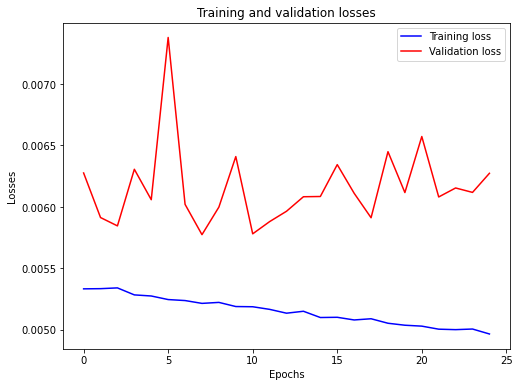

In [914]:
plot_train_history(LSTMIMO)

In [1187]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [1188]:
baseline = Baseline(label_index = 0)

baseline.compile(loss=tf.losses.MeanSquaredError(), metrics=[tf.metrics.MeanSquaredError()])

performance['Baseline'] = baseline.evaluate(test_inputs['target'].reshape(-1,24,1), verbose=0)

In [1189]:
predictions_B = baseline.predict(test_inputs['X'])
eval_df_B = create_evaluation_df(predictions_B.reshape(-1,24), test_inputs, HORIZON, y_scaler)
mape(eval_df_B['prediction'], eval_df_B['actual'])

0.06743083253596528

[]

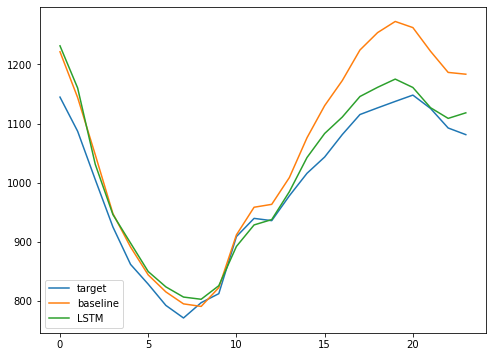

In [1181]:
import random
i = random.randint(1,8740)
plt.plot(y_scaler.inverse_transform(test_inputs.dataframe.loc[:,'target'])[i].reshape(24,-1), label='target')
plt.plot(y_scaler.inverse_transform(predictions_B.reshape(-1,24))[i], label='baseline')
plt.plot(y_scaler.inverse_transform(predictions.reshape(-1,24))[i], label='LSTM')
plt.legend()
[]

In [960]:
y_scaler.inverse_transform(test_inputs.dataframe.loc[:,'target'])[0]

array([1302.90134965, 1263.01115434, 1245.23993228, 1234.03319732,
       1229.0868185 , 1242.63234953, 1282.87105111, 1340.57221562,
       1389.61922675, 1416.99283621, 1449.5631594 , 1468.04174211,
       1463.25077609, 1444.11148536, 1424.2370775 , 1409.97785442,
       1398.62701022, 1399.04496706, 1422.74186493, 1445.8555856 ,
       1425.22780972, 1380.93905543, 1326.4974681 , 1252.69754853])

In [482]:
eval_df_B['APE'] = (eval_df_B['prediction'] - eval_df_B['actual']).abs() / eval_df_B['actual']
df = eval_df_B.groupby('h')['APE'].mean()
df.reindex(['t+1', 't+2', 't+3', 't+4', 't+5', 't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14', 't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23', 't+24'])

h
t+1     0.067245
t+2     0.067253
t+3     0.067263
t+4     0.067280
t+5     0.067306
t+6     0.067336
t+7     0.067362
t+8     0.067385
t+9     0.067404
t+10    0.067422
t+11    0.067440
t+12    0.067460
t+13    0.067475
t+14    0.067485
t+15    0.067496
t+16    0.067504
t+17    0.067511
t+18    0.067514
t+19    0.067519
t+20    0.067525
t+21    0.067529
t+22    0.067536
t+23    0.067542
t+24    0.067548
Name: APE, dtype: float64

In [1182]:
val_performance = {}
performance = {}
mape_performance = {}
performance['LSTM-MIMO'] = LSTMIMO.evaluate(test_inputs['X'],test_inputs['target'].reshape(-1,24,1), verbose=0)

In [1183]:
predictions = LSTMIMO.predict(test_inputs['X'])

In [1184]:
eval_df = create_evaluation_df(predictions.reshape(-1,24), test_inputs, HORIZON, y_scaler)
eval_df.head(29)

,timestamp,h,prediction,actual
0,2015-01-01 23:00:00,t+1,1338.967973,1302.901350
1,2015-01-02 00:00:00,t+1,1320.540553,1263.011154
2,2015-01-02 01:00:00,t+1,1304.271103,1245.239932
3,2015-01-02 02:00:00,t+1,1302.918578,1234.033197
4,2015-01-02 03:00:00,t+1,1304.207368,1229.086818
5,2015-01-02 04:00:00,t+1,1314.316958,1242.632350
6,2015-01-02 05:00:00,t+1,1335.590179,1282.871051
7,2015-01-02 06:00:00,t+1,1366.861790,1340.572216
8,2015-01-02 07:00:00,t+1,1391.501585,1389.619227
9,2015-01-02 08:00:00,t+1,1415.470752,1416.992836


In [1185]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
df = eval_df.groupby('h')['APE'].mean()
df.reindex(['t+1', 't+2', 't+3', 't+4', 't+5', 't+6', 't+7', 't+8', 't+9', 't+10', 't+11', 't+12', 't+13', 't+14', 't+15', 't+16', 't+17', 't+18', 't+19', 't+20', 't+21', 't+22', 't+23', 't+24'])

h
t+1     0.067027
t+2     0.068320
t+3     0.068509
t+4     0.068498
t+5     0.068760
t+6     0.069136
t+7     0.069575
t+8     0.069941
t+9     0.070182
t+10    0.070257
t+11    0.070223
t+12    0.070129
t+13    0.070036
t+14    0.070021
t+15    0.070085
t+16    0.070186
t+17    0.070312
t+18    0.070463
t+19    0.070642
t+20    0.070873
t+21    0.071147
t+22    0.071430
t+23    0.071658
t+24    0.071828
Name: APE, dtype: float64

In [1186]:
mape(eval_df['prediction'], eval_df['actual'])

0.06996815887512287

In [1175]:
MAX_EPOCHS = 100
BATCHSIZE = 32
patience = 100

ConditionalRNN = Sequential(layers=[ConditionalRNN(32, cell='LSTM', return_sequences=True),
                                    Dense(1)])

In [1176]:
ConditionalRNN.compile(optimizer=tf.optimizers.Adam(), loss='mse', metrics=[tf.metrics.MeanSquaredError()])

In [985]:
ConditionalRNN.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [1177]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
tf.keras.backend.set_floatx('float64')
history = ConditionalRNN.fit([train_inputs['X'],train_c1,train_c2], train_inputs['target'].reshape(-1,24,1), batch_size=32, epochs=MAX_EPOCHS,
                  validation_split=0.15,
                  callbacks=[early_stopping], verbose=1)

Epoch 1/100
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
689/690 [============================>.] - ETA: 0s - loss: 0.0114 - mean_squared_error: 0.0114WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'tuple'> input: (<tf.Tensor 'IteratorGetNext:0' shape=(None, 24, 6) dtype=float64>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 8) dtype=float64>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 2) dtype=float64>)
Consider rewriting this model with the Functional API.
690/690 [==============================] - 12s 17ms/step - loss: 0.0114 - mean_squared_error: 0.0114 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 2/100
690/690 [==============================] - 12s 17ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0066 - val_mean_squared_error: 0.0066
Epoch 3/100
690/690 [==============================] - 11s 16ms/step - loss: 0.0061 - mea

690/690 [==============================] - 9s 13ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 44/100
690/690 [==============================] - 11s 17ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 45/100
690/690 [==============================] - 11s 16ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 46/100
690/690 [==============================] - 11s 16ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 47/100
690/690 [==============================] - 10s 15ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 48/100
690/690 [==============================] - 11s 16ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0059 - val_mean_squared_error: 0.0059
Epoch 49/100
690/6

690/690 [==============================] - 11s 16ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 93/100
690/690 [==============================] - 11s 17ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoch 94/100
690/690 [==============================] - 12s 17ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 95/100
690/690 [==============================] - 11s 16ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 96/100
690/690 [==============================] - 11s 16ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 97/100
690/690 [==============================] - 11s 16ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 98/100
690/

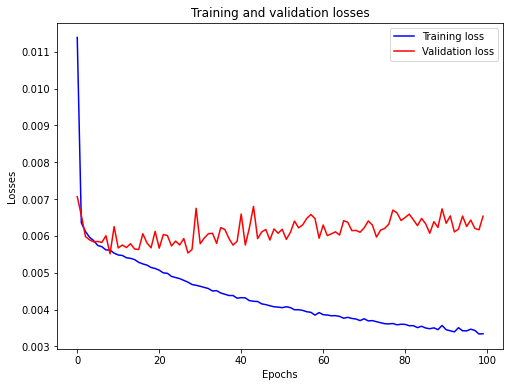

In [1178]:
plot_train_history(ConditionalRNN)

In [741]:
train_c2.iloc[24:26]

,value(t-24),value(t-168)
2012-01-09 00:00:00,0.242102,0.310261
2012-01-09 01:00:00,0.222242,0.297814


In [742]:
train_inputs.dataframe.head(2)['target']

feature                     y                                          \
time step                 t+1       t+2       t+3       t+4       t+5   
2012-01-08 00:00:00  0.222242  0.212580  0.213599  0.224284  0.236913   
2012-01-08 01:00:00  0.212580  0.213599  0.224284  0.236913  0.262734   

feature                                                                ...  \
time step                 t+6       t+7       t+8       t+9      t+10  ...   
2012-01-08 00:00:00  0.262734  0.295024  0.333978  0.361023  0.361988  ...   
2012-01-08 01:00:00  0.295024  0.333978  0.361023  0.361988  0.341180  ...   

feature                                                                \
time step                t+15      t+16      t+17      t+18      t+19   
2012-01-08 00:00:00  0.273947  0.266290  0.270527  0.300126  0.348581   
2012-01-08 01:00:00  0.266290  0.270527  0.300126  0.348581  0.351598   

feature                                                                
time step                t+20      t+21      t+22      t+23      t+24  
2012-01-08 00:00:00  0.351598  0.340260  0.313293  0.271941  0.227715  
2012-01-08 01:00:00  0.340260  0.313293  0.271941  0.227715  0.206421  

[2 rows x 24 columns]

In [428]:
df2 = df.merge(series_to_supervised(df), how='right', left_index=True, right_index=True)

In [46]:
w2 = WindowGenerator(input_width=24, label_width=24, shift=24, train_df=train_df_short, test_df=test_df_short,
                     label_columns=['value'])
w2

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['value']

In [51]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

In [374]:
example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')


All shapes are: (batch, time, features)
Window shape: (3, 48, 14)
Inputs shape: (3, 24, 14)
labels shape: (3, 24, 1)


In [375]:
w2.train.element_spec

(TensorSpec(shape=(None, 24, 14), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))

In [376]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')


Inputs shape (batch, time, features): (32, 24, 14)
Labels shape (batch, time, features): (32, 24, 1)


In [58]:
def validation(forecasted, real, parameter):
    ''' 
    compute some important parameters to compare forecasting results
    '''
    value = 0
    value_1 = 0
    value_2 = 0

    if parameter == 'SMAPE':
        for i in range(len(forecasted)):
            if real[i] + forecasted[i] == 0:
                value += 0
            else: 
                value += ((abs(real[i] - forecasted[i])) / (real[i] + forecasted[i])) * 100
        final_value = value / len(forecasted)  

    elif parameter == 'MAPE':
        for i in range(len(forecasted)):
            if real[i] == 0:
                value += 0
            else: 
                value += (abs(real[i] - forecasted[i]))/real[i]
        final_value = value / len(forecasted) * 100

    elif parameter == 'RMSE':
        for i in range(len(forecasted)):
            value += (real[i] - forecasted[i]) ** 2
        final_value = (value / len(forecasted)) ** (1 / 2) 

    elif parameter == 'R':
        for i in range(len(forecasted)):
            value += (real[i] - np.mean(real)) * (forecasted[i] - np.mean(forecasted))
            value_1 += (real[i] - np.mean(real)) ** 2
            value_2 += (forecasted[i] - np.mean(forecasted)) ** 2

        if value_1 == 0 or value_2 == 0:
            final_value = 100
        else:
            final_value = (value / ((value_1 ** (1 / 2)) * (value_2 ** (1 / 2))))*100

    return final_value

In [221]:
def MAPE(model, window):
    actual = []
    forecasted = []
    for inputs, labels in window.test:
        yhat = y[0] in model.predict(inputs)
        print(yhat.shape)
        print(labels.shape)
        labels = scaler.inverse_transform(np.array(labels).reshape(-1,1))
        yhat = model.predict(inputs)
        yhat = scaler.inverse_transform(yhat.reshape(-1,1))
        actual.append(labels)
        forecasted.append(yhat)
    actual = itertools.chain(*actual)
    forecasted = itertools.chain(*forecasted)
    mape = validation(list(actual), list(forecasted), 'MAPE')
    print('MAPE: %f %%' % mape)
    return(mape)

In [316]:
plot_col = 'value'
label_col_index = w2.label_columns_indices.get(plot_col, None)
inputs = np.concatenate([x for x, y in w2.test], axis=0)
labels = np.concatenate([y for x, y in w2.test], axis=0)
yhat = lstm_model(inputs)[:,:,label_col_index]
#yhat = scaler.inverse_transform()
yhat = tf.reshape(yhat, [-1,24,1])
print(yhat.shape)
print(inputs.shape)
print(labels.shape)
#print(np.concatenate((inputs[:,:,1:],yhat),axis=2).shape)
inv_yhat = np.concatenate((yhat,inputs[:,:,1:]),axis=2)
inv_yhat = scaler.inverse_transform(inv_yhat.reshape(-1,14))
pred = [i[0] for i in inv_yhat]
inv_y = np.concatenate((labels,inputs[:,:,1:]),axis=2)
inv_y = scaler.inverse_transform(inv_y.reshape(-1,14))
act = [i[0] for i in inv_y]
print(pred[:5])
print(act[:5])
mape = validation(pred, act, 'MAPE')
print('MAPE: %f %%' % mape)

(8713, 24, 1)
(8713, 24, 14)
(8713, 24, 1)
[853.853, 820.3377, 802.64703, 793.2433, 805.04376]
[815.1598, 859.4295, 864.9292, 881.81396, 895.4568]
MAPE: 25.572377 %


In [107]:
MAX_EPOCHS = 10

def compile_and_fit(model, window, patience=50):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanSquaredError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [250]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, w2)

#IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( w2.val)
performance['LSTM'] = lstm_model.evaluate( w2.test, verbose=0)
mape_performance['LSTM'] = MAPE(lstm_model, w2)

print()

Epoch 1/10
698/698 [==============================] - 12s 17ms/step - loss: 0.0174 - mean_squared_error: 0.0174 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 2/10
698/698 [==============================] - 12s 17ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 3/10
698/698 [==============================] - 11s 15ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 4/10
698/698 [==============================] - 12s 17ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 5/10
698/698 [==============================] - 11s 16ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0070 - val_mean_squared_error: 0.0070
Epoch 6/10
698/698 [==============================] - 11s 16ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 7/10
698/6

NameError: name 'y' is not defined

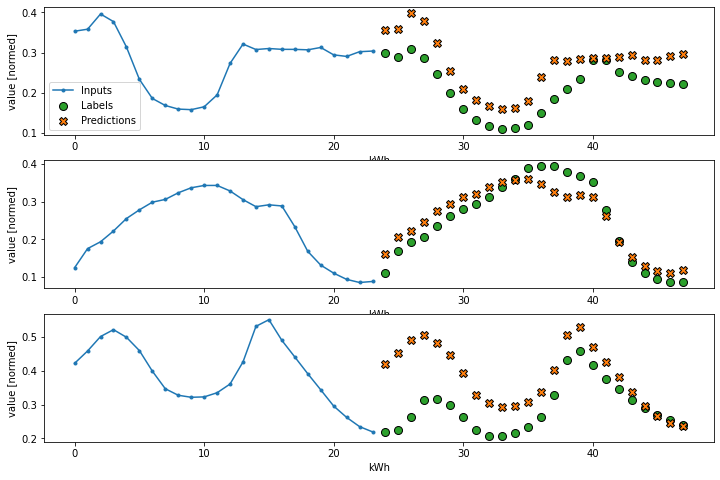

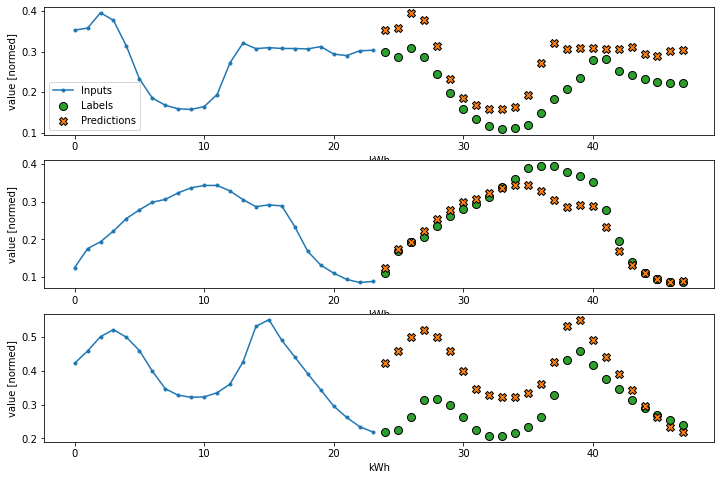

In [194]:
w2.plot(lstm_model)
w2.plot(baseline)

In [11]:
def gradient_importance(seq, model):    
    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)    
    
    with tf.GradientTape() as tape:
        predictions = model(seq)    
    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads

In [ ]:
cols = df.columns
#datach = deep_learner.normalize(datach)
#df = df.iloc[:,1:]
df.shape

In [ ]:
#features = cols[1:]
features = cols
importances = gradient_importance(np.array(df[:1000]), lstm_model)
indices = np.argsort(importances)
print(len(features))
print(len(importances))

plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
lstm_model2 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model2, w2)

#IPython.display.clear_output()
val_performance['LSTM 2 layer'] = lstm_model.evaluate( w2.val)
performance['LSTM 2 layer'] = lstm_model.evaluate( w2.test, verbose=0)

print()


In [ ]:
w2.plot(residual_lstm)

In [ ]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # The prediction for each timestep is the input
        # from the previous time step plus the delta
        # calculated by the model.
        return inputs + delta

In [ ]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, w2)

#IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(w2.val)
performance['Residual LSTM'] = residual_lstm.evaluate(w2.test, verbose=0)
print()


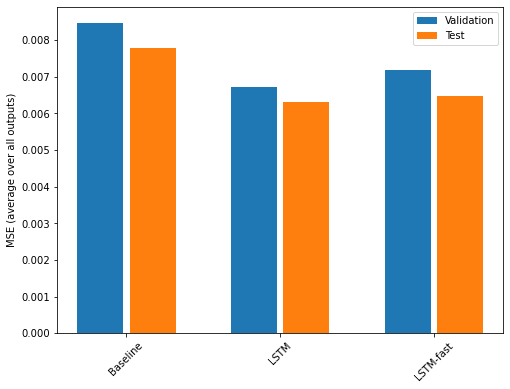

In [179]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_squared_error'
metric_index = lstm_model.metrics_names.index('mean_squared_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MSE (average over all outputs)')
_ = plt.legend()

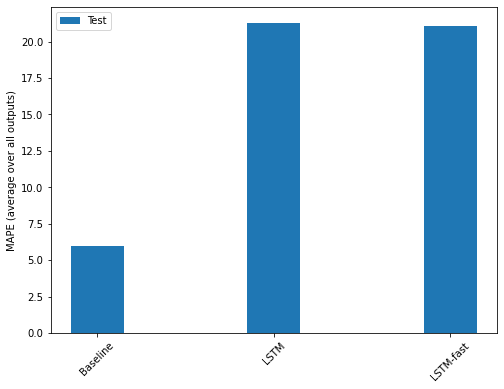

In [188]:
x = np.arange(len(mape_performance))
width = 0.3

metric_name = 'mean_average_performance_error'
#metric_index = lstm_model.metrics_names.index('mape')
test_mape = mape_performance.values()

plt.bar(x, list(itertools.chain(*test_mape)), width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAPE (average over all outputs)')
_ = plt.legend()

In [166]:
list(itertools.chain(*test_mape))

[23.450996430740464]